In [1]:
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from random import randint

from load_data import gen_data,load_data,standardize
import pandas as pd

In [2]:
tf.reset_default_graph()

num_steps = 200


input_num = 5
output_num = 1

state_size = 80

num_layers = 6

def lrelu(x, name, leak=0.2): 
    #return tf.maximum(x, leak * x, name=name) 
    return tf.maximum(x, 0, name=name) 

In [3]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, num_steps,input_num], name='input_placeholder')
y = tf.placeholder(tf.float32, [None], name='labels_placeholder')

keep_prob = tf.placeholder_with_default(1.0, shape=())

#is_train = tf.placeholder_with_default(False, shape=())

x_reshaped = tf.reshape(x,[tf.shape(x)[0],x.shape[1],1,x.shape[2]])


rnn_inputs = tf.squeeze(x_reshaped,axis=2)


In [4]:
print(x_reshaped)
#print(conv1)
#print(conv2)
#print(pool1)


Tensor("Reshape:0", shape=(?, 200, 1, 5), dtype=float32)


In [5]:



cells = []
for i in range(0, num_layers):
    cell = tf.contrib.rnn.LSTMCell(state_size )
    cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    cells.append(cell)
    
mul_cell = tf.nn.rnn_cell.MultiRNNCell(cells)

rnn_outputs, final_state = tf.nn.dynamic_rnn(mul_cell, rnn_inputs, dtype=tf.float32)



In [6]:
rnn_outputs_reshaped = tf.reshape(rnn_outputs,[tf.shape(rnn_outputs)[0],
                                               rnn_outputs.shape[1],1,rnn_outputs.shape[2]])

#############################################################

conv5 = lrelu(tf.layers.conv2d(rnn_outputs_reshaped, name="conv5", filters = 64, 
                         kernel_size = [4,1],strides = [1,1],padding = "valid", activation = None),"conv5_lrelu")
#bn1 = tf.layers.batch_normalization(conv5, training = is_train)

conv6 = lrelu(tf.layers.conv2d(conv5, name="conv6", filters = 128, 
                         kernel_size = [4,1],strides = [1,1],padding = "valid", activation = None),"conv6_lrelu")
#bn2 = tf.layers.batch_normalization(conv6, training = is_train)

pool3 = tf.layers.max_pooling2d(inputs=conv6, name = "pool3", pool_size=[2, 1], strides=[2,1])

#############################################################

conv7 = lrelu(tf.layers.conv2d(pool3, name="conv7", filters = 64, 
                         kernel_size = [4,1],strides = [1,1],padding = "valid", activation = None),"conv7_lrelu")
#bn3 = tf.layers.batch_normalization(conv7, training = is_train)


conv8 = lrelu(tf.layers.conv2d(conv7, name="conv8", filters = 128, 
                         kernel_size = [4,1],strides = [1,1],padding = "valid", activation = None),"conv8_lrelu")
#bn4 = tf.layers.batch_normalization(conv8, training = is_train)


pool4 = tf.layers.max_pooling2d(inputs=conv8, name = "pool4", pool_size=[2, 1], strides=[2,1])

#############################################################

conv9 = lrelu(tf.layers.conv2d(pool4, name="conv9", filters = 32, 
                         kernel_size = [4,1],strides = [1,1],padding = "valid", activation = None),"conv9_lrelu")
#bn5 = tf.layers.batch_normalization(conv9, training = is_train)


conv10 = lrelu(tf.layers.conv2d(conv9, name="conv10", filters = 64, 
                         kernel_size = [4,1],strides = [1,1],padding = "valid", activation = None),"conv10_lrelu")
#bn6 = tf.layers.batch_normalization(conv10, training = is_train)



pool5 = tf.layers.max_pooling2d(inputs=conv10, name = "pool5", pool_size=[2, 1], strides=[2,1])

#############################################################

pool5_flat = tf.reshape(pool5,[tf.shape(pool5)[0],pool5.shape[1]*pool5.shape[2]*pool5.shape[3]])


#rnn_outputs_flat = tf.reshape(rnn_outputs,[tf.shape(rnn_outputs)[0],rnn_outputs.shape[1]*rnn_outputs.shape[2]])
dense1 = tf.layers.dense(pool5_flat,512,name="dense1")
dense2 = tf.layers.dense(dense1,output_num,name="dense2")

logits = tf.squeeze(dense2,axis=1)

In [7]:
print(rnn_outputs_reshaped)
print(" ")
print(conv5)
print(conv6)
print(pool3)
print(" ")
print(conv7)
print(conv8)
print(pool4)
print(" ")
print(conv9)
print(conv10)

print(" ")
print(dense1)
print(dense2)

Tensor("Reshape_1:0", shape=(?, 200, 1, 80), dtype=float32)
 
Tensor("conv5_lrelu:0", shape=(?, 197, 1, 64), dtype=float32)
Tensor("conv6_lrelu:0", shape=(?, 194, 1, 128), dtype=float32)
Tensor("pool3/MaxPool:0", shape=(?, 97, 1, 128), dtype=float32)
 
Tensor("conv7_lrelu:0", shape=(?, 94, 1, 64), dtype=float32)
Tensor("conv8_lrelu:0", shape=(?, 91, 1, 128), dtype=float32)
Tensor("pool4/MaxPool:0", shape=(?, 45, 1, 128), dtype=float32)
 
Tensor("conv9_lrelu:0", shape=(?, 42, 1, 32), dtype=float32)
Tensor("conv10_lrelu:0", shape=(?, 39, 1, 64), dtype=float32)
 
Tensor("dense1/BiasAdd:0", shape=(?, 512), dtype=float32)
Tensor("dense2/BiasAdd:0", shape=(?, 1), dtype=float32)


In [8]:


loss = tf.reduce_mean(tf.square(y - logits))
loss_sum = tf.summary.scalar('Loss', loss)

optimizer = tf.train.AdamOptimizer(learning_rate = 0.0005)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = optimizer.minimize(loss)

In [9]:

batch_size = 50

merged = tf.summary.merge_all()
saver = tf.train.Saver()
init = tf.global_variables_initializer()
sess = tf.Session()

checkpoint_path = "./logs/ET"


resample="2H"

restore_checkpoint = True
save = True
tensorboard = True


if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
    saver.restore(sess, checkpoint_path)
else:
    sess.run(init)

INFO:tensorflow:Restoring parameters from ./logs/ET


In [11]:
train_data = load_data(["Calgary","London"],['2013','2014'],resample=resample)
#train_data = load_data(["Calgary"],['2013'],resample=resample)


Calgary Energy Balance 5min 2013
Calgary Water Balance 5min 2013
Calgary Lysimeters kg 5min2013


/notebooks/Recurrent/load_data.py:77: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  'Wind': "mean",'Rain': "sum",'Lysimeter': "mean"})


London Energy Balance 5min 2013
London Water Balance 5min 2013
London Lysimeters kg 5min2013
Calgary Energy Balance 5min 2014
Calgary Water Balance 5min 2014
Calgary Lysimeters kg 5min2014
London Energy Balance 5min 2014
London Water Balance 5min 2014
London Lysimeters kg 5min2014


/usr/local/lib/python3.5/dist-packages/pandas/core/indexes/base.py:2245: FutureWarning: In the future, 'NAT < x' and 'x < NAT' will always be False.
  self._values[0] < other_diff[0]


In [ ]:
print("Starting Training")
train_writer = tf.summary.FileWriter('logs/train',
                                    sess.graph)
step = 305
n_iterations = 15000 - step
for i,(x_,y_) in enumerate(gen_data(batch_size,num_steps,
                                    train_data,shuffle=True,n_iterations=n_iterations)):
    #print(x_[0])
    if(y_.shape[0] == 0):
        continue

    _,loss_,pred,summary = sess.run([train_step,loss,logits,merged],
                                    feed_dict = {x : x_, y: y_, keep_prob : 0.8})

    if tensorboard:
        train_writer.add_summary(summary, step)

    if(i % 25 == 0):
        print("Step : {}  loss : {}  \nreal : {}   \npred : {}\n".format(step, loss_,
                                                                                       y_[0:3],pred[0:3]))
        if save:
            save_path = saver.save(sess, checkpoint_path)
    step+=1
    

Starting Training
Step : 305  loss : 1.6935381889343262  
real : [ 13.80039715  13.28622225  14.17285577]   
pred : [ 14.24129486  14.72443199  15.81780529]

Step : 330  loss : 1.786769986152649  
real : [ 13.51470258  12.69311935  14.49088509]   
pred : [ 14.15196705  14.47507     13.13553524]

Step : 355  loss : 1.2188788652420044  
real : [ 13.74983534  14.94982163  14.53816804]   
pred : [ 16.25978088  14.57476902  14.03418255]

Step : 380  loss : 1.1408065557479858  
real : [ 13.87609326  14.94982163  13.83672573]   
pred : [ 11.99589634  14.1658268   14.20752811]

Step : 405  loss : 1.1241989135742188  
real : [ 16.58208551  16.36495299  14.54740456]   
pred : [ 17.166008    15.74359894  14.23041534]

Step : 430  loss : 1.7005789279937744  
real : [ 13.05425467  13.84057768  16.63374733]   
pred : [ 13.10794735  14.04120541  13.85040379]

Step : 455  loss : 1.282101035118103  
real : [ 13.42587556  15.77186615  17.87278166]   
pred : [ 15.09550762  15.08304691  19.8351078 ]

Step

Step : 1780  loss : 1.581230640411377  
real : [ 14.3347991   16.25761073  16.89113722]   
pred : [ 15.62805557  17.24364853  18.80257988]

Step : 1805  loss : 1.1559019088745117  
real : [ 13.91729268  15.236389    13.96186072]   
pred : [ 14.34927177  14.78631783  16.1844101 ]

Step : 1830  loss : 1.7097136974334717  
real : [ 16.64130248  18.10884879  13.85844381]   
pred : [ 16.90582085  20.73955536  14.56625557]

Step : 1855  loss : 1.8379144668579102  
real : [ 14.18026525  17.06570675  17.08401   ]   
pred : [ 15.60383797  17.42197418  17.36881256]

Step : 1880  loss : 0.4763198792934418  
real : [ 12.20486296  16.46449382  11.72763694]   
pred : [ 11.8552618   15.39483356  12.58041382]

Step : 1905  loss : 0.4967728555202484  
real : [ 11.85515097  14.44469619  15.42900869]   
pred : [ 12.81297016  15.66137695  16.04311752]

Step : 1930  loss : 1.0006077289581299  
real : [ 16.90658228  14.20644302  17.5498564 ]   
pred : [ 15.99274921  15.60336208  18.00540924]

Step : 1955  l

Step : 3255  loss : 0.42013514041900635  
real : [ 13.06689968  19.19831504  12.94067806]   
pred : [ 13.24608135  19.50259018  12.93791008]

Step : 3280  loss : 0.8928426504135132  
real : [ 16.98074216  14.32999451  16.78193019]   
pred : [ 15.91061497  13.85345268  16.12127304]

Step : 3305  loss : 0.25822436809539795  
real : [ 16.6024655   15.55913114  18.78673733]   
pred : [ 15.87665749  15.36419201  19.17637825]

Step : 3330  loss : 0.6152482628822327  
real : [ 17.1213269   13.52350048  16.86246992]   
pred : [ 17.97829247  13.02054787  16.16657448]

Step : 3355  loss : 0.6659210324287415  
real : [ 14.29039504  12.69311935  13.22052926]   
pred : [ 14.62173271  13.45103741  13.41719246]

Step : 3380  loss : 0.518602728843689  
real : [ 14.28778234  12.67614317  16.33375439]   
pred : [ 14.71456051  12.89746761  15.53874302]

Step : 3405  loss : 0.3007011413574219  
real : [ 15.75426026  15.87905365  13.68743177]   
pred : [ 16.52566719  16.28069878  14.37947845]

Step : 3430 

In [15]:
test_data = load_data(["Halifax"],['2013'],resample=resample)

Halifax Energy Balance 5min 2013
Halifax Water Balance 5min 2013
Halifax Lysimeters kg 5min2013


/notebooks/Recurrent/load_data.py:77: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  'Wind': "mean",'Rain': "sum",'Lysimeter': "mean"})


In [16]:
pred_data = test_data[0][['Lysimeter']]
pred_data.Lysimeter.iloc[0:num_steps] = 0
for i,(x_,y_) in enumerate(gen_data(1,num_steps,test_data)):
    if(x_.shape[0] == 0):
        continue
    #print(y_)
    
    pred = sess.run([logits], feed_dict = {x : x_ ,  keep_prob : 1})
    pred_data.Lysimeter.iloc[i+num_steps-1] = pred[0]
    #print(pred_data.iloc[i+num_steps-1])
    #if i > 5:
    #    break
    if i % 50 == 0:
        print("Iteration : {}  \nreal : {}   \npred : {}\n".format(i, y_[0:3],pred[0][0:3]))
    
   # if i >= 300:
    #    break
    
print("done")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Iteration : 0  
real : [ 12.85538989]   
pred : [ 15.81344604]

Iteration : 50  
real : [ 14.32238941]   
pred : [ 15.31957245]

Iteration : 100  
real : [ 14.12641314]   
pred : [ 15.10767651]

Iteration : 150  
real : [ 13.68454541]   
pred : [ 14.79423237]

Iteration : 200  
real : [ 16.19634302]   
pred : [ 16.43298531]

Iteration : 250  
real : [ 16.00943825]   
pred : [ 16.41513062]

Iteration : 300  
real : [ 15.64732953]   
pred : [ 16.76312065]

Iteration : 350  
real : [ 16.55441535]   
pred : [ 17.14958763]

Iteration : 400  
real : [ 15.76908648]   
pred : [ 16.2614727]

Iteration : 450  
real : [ 16.69262015]   
pred : [ 14.2934885]

Iteration : 500  
real : [ 16.13483198]   
pred : [ 16.38731384]

Iteration : 550  
real : [ 16.33598256]   
pred : [ 16.71316338]

Iteration : 600  
real : [ 15.96686627]   
pred : [ 17.05530548]

Iteration : 650  
real : [ 15.94554843]   
pred : [ 15.7960577]

Iteration : 700  
real : [ 15.58133918]   
pred : [ 16.09435654]

Iteration : 750 

In [17]:
pred_rename = pred_data.rename(index=str, columns={"Lysimeter" : "Predicted Weight"})
real_rename = test_data[0][['Lysimeter']].rename(index=str, columns={"Lysimeter" : "Real Lysimeter"})

result = pd.concat([real_rename, pred_rename] , axis=1)
                    


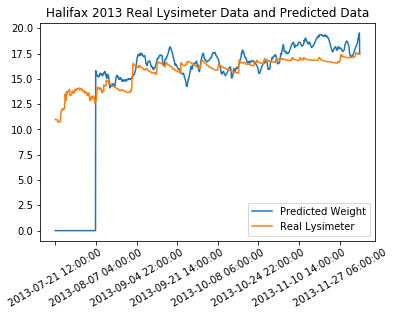

In [32]:
result[['Predicted Weight','Real Lysimeter']].plot()
#ax.show()
#print("yeet")
plt.title("Halifax 2013 Real Lysimeter Data and Predicted Data")
plt.xticks(rotation=30) 
plt.show()

In [ ]:
print("df")

In [21]:
print(pred_data.shape[0])

1499
